[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ciminilab/2022_Garcia-Fossa_submitted/blob/main/basic_protocol_2/notebook/Basic_Protocol_2.ipynb)

# **Visualize random or representative cell in a given group and field of view**

## Before running, click on **+ Copy to my Drive** to have your own copy of the notebook.

- **What are the inputs necessary to run this notebook?** You don't have to worry if you don't have your own data, you can use an example from our GitHub.

- **What if I wanna run this notebook with my own data?** 
 

1.  Before anything else, you need a table with feature information on the columns, and single-cell information on rows. We recommend to use CellProfiler outputs, since they will be in the same format;
2.   Then you need to mount this notebook on your Google Drive, so it can access your images and table;
3. Don't forget to change the Inputs on Section 2 to match your data's name and path.




        
## Steps:

1. Import libraries
2. Define inputs 
3.a) Import dataset, normalize and feature select and 3.b) Import pre processed dataset
4. Choose the information to plot
5. Calculate correlations
6. Visualize!

  

# **1. Import libraries**

Installing the libraries will take about 5 minutes to run.

In [1]:
#@title Clone GitHub and pip install functions

#@markdown * This step will clone the GitHub repository presented on the Interpreting Image-Based Profiles paper. 


!git clone https://github.com/ciminilab/2022_Garcia-Fossa_submitted

%cd /content/2022_Garcia-Fossa_submitted/
!pip install ./utils

Cloning into '2022_Garcia-Fossa_submitted'...
remote: Enumerating objects: 774, done.
remote: Counting objects: 100% (250/250), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 774 (delta 142), reused 240 (delta 133), pack-reused 524
Receiving objects: 100% (774/774), 569.75 MiB | 16.91 MiB/s, done.
Resolving deltas: 100% (196/196), done.
Updating files: 100% (431/431), done.
/content/2022_Garcia-Fossa_submitted
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./utils
  Preparing metadata (setup.py) ... done
  Created wheel for utils: filename=utils-1.0-py3-none-any.whl size=1037 sha256=1c74967bb30ad22794c1bd139d7cf0e6400f129db0477500416be5cb386d8bbf
  Stored in directory: /tmp/pip-ephem-wheel-cache-48tyevwu/wheels/fc/fe/57/a43f342531bb9c5e7a1bcda65d226a9394e2eb74cb64f3220c
Successfully built utils


In [2]:
#@title Pip install needed libraries and import libraries

#@markdown * This step will take about 5 minutes to run.

!pip install pyarrow==9
!pip install git+https://github.com/cytomining/pycytominer
!pip install openpyxl
!pip install scikit-image
!pip install hdmedians
!pip install scikit-fda
!pip install GPy
!pip install matplotlib-scalebar


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cytomining/pycytominer to /tmp/pip-req-build-kzio1xip
  Running command git clone --filter=blob:none --quiet https://github.com/cytomining/pycytominer /tmp/pip-req-build-kzio1xip
  Resolved https://github.com/cytomining/pycytominer to commit afac3ea16818ad25f37318ecd5c5090c0eff5806
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 KB 8.0 MB/s eta 0:00:00
  Created wheel for pycytominer: filename=pycytominer-0.2.0-py2.py3-none-any.whl size=259572355 sha256=788f5bca506bd44324a4eabaef7e5fe67aea5f54b1fb0fbf238b3301162c4598
  Stored in directory: /tmp/pip-ephem-wheel-cache-_37cwo2u/wheels/51/e1/e6/5ae6bb55d507fe4b0864268cc3dff0a27526385565196af4f9
Successfully built pycytominer
  Attempting uninstall: pluggy
    Found ex

In [46]:
#@title Import libraries

%matplotlib notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from utils.read_data import *
from utils.visualize_data import *
from utils.correlations import *
from sklearn.cluster import KMeans
from openpyxl import Workbook, load_workbook
import os
import pycytominer
from google.colab import files
from matplotlib_scalebar.scalebar import ScaleBar

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# **2. Define inputs**



* Here we define the file_name, dataset_path and images_dir based on the path we have on our GitHub repository.

    -  **file_name** - name for a csv file
    -  **dataset_path** - path to file_name
    -  **images_dir** - path to images (can be our GitHub repo or your local directory to test with your own images)
    -  **box_size** - size of box in pixels for cropping a cell
    -  **channels** - list of channels you want to plot



In [5]:
file_name =  r"/BasicProtocols2_Example_Raw.zip"

dataset_path = r'/content/2022_Garcia-Fossa_submitted/basic_protocol_2/data'

images_dir = r"/content/2022_Garcia-Fossa_submitted/basic_protocol_2/images" #give the directory of where pictures are

metadata_dir = r"/content/2022_Garcia-Fossa_submitted/basic_protocol_2/metadata"

metadata_file = r"/metadata.csv"

box_size = 150

channels = ["DNA","ER","RNA","AGP","Mito"]

In [ ]:
#@title Run this cell only if you want to run with your own data instead the ones in our GitHub repo.

#@markdown * This cell will mount Colab on your own Google Drive, and ask for the inputs.

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

file_name_input =  input(r"Provide file_name:")
file_name = "/" + file_name_input

dataset_path_input = input(r"Provide the path to file_name:")
dataset_path = "/" + dataset_path_input

images_dir_input = input(r"Provide the path to your images:")
images_dir = "/" + images_dir_input

box_size_input = input("Size of the box to crop the cells, in pixels:")
box_size = int(box_size_input)

channels = [item for item in input("Provide a list of names for the channels you want to plot. Give them separated by space like: DNA RNA ER").split()]

# **3a. Import dataset, normalize and feature select**

- To import raw data and normalize and feature select it, run this section
- Run this section to demo our notebook.

In [170]:
#@title **3a1. Import dataset**

df = pd.read_csv(dataset_path+file_name, low_memory=False)

In [171]:
#@title **3a2. Metadata import and annotate dataset - if having metadata already, SKIP THIS STEP**

metadata = pd.read_csv(metadata_dir+metadata_file, low_memory=False)

In [172]:
#@title Annotate dataset using pycytominer

df = pycytominer.annotate(profiles = df, platemap = metadata, join_on =  ["Metadata_Well", "Image_Metadata_Well"])

## **3a3. Normalization steps**

1. We select a few columns' names we want to keep related to Metadata and Image_Filename
2. We retrieve 'Nuclei_Location_Center_X' and 'Nuclei_Location_Center_Y' columns to NOT be normalized during this process, and add it again later
3. Choose negative control to normalize to
4. Normalize using mad_robustize

For more information on normalization by pycytominer and other methods, see their [documentation](https://pycytominer.readthedocs.io/en/latest/)

In [132]:
#@title **Select a few columns to keep before normalization**
list_cols = ['Metadata_', 'Image_FileName_Orig', 'Image_Width_OrigDNA']
cols_keep = []
for cols in df.columns:
  for items in list_cols:
    if cols.startswith(items):
      cols_keep.append(cols)
print(cols_keep)

#keep location columns elsewhere and drop them from df
df_loc = df[['Nuclei_Location_Center_X', 'Nuclei_Location_Center_Y']]
df = df.drop(columns=['Nuclei_Location_Center_X', 'Nuclei_Location_Center_Y'])

['Metadata_Concentration', 'Metadata_moa', 'Metadata_Compound', 'Metadata_Plate', 'Metadata_Well', 'Image_FileName_OrigAGP', 'Image_FileName_OrigDNA', 'Image_FileName_OrigER', 'Image_FileName_OrigMito', 'Image_FileName_OrigRNA', 'Image_Width_OrigDNA']


In [173]:
#@title Please run to activate dropdown function
def dropdown(input_list):
  import ipywidgets as widgets
  global dropdown_output
  drop_down = widgets.Dropdown(options=input_list,
                                  description='Choose',
                                  disabled=False)

  def dropdown_handler(change):
      global dropdown_output
      dropdown_output = change.new  # This line isn't working
  drop_down.observe(dropdown_handler, names='value')
  display(drop_down)
  dropdown_output = drop_down.value


In [174]:
#@title Choose a label column where your **negative control** is. Please choose **"Metadata_compound"** for this demo
df_list = [option for option in df.filter(regex=r'Metadata', axis=1).columns]
dropdown(df_list)

Dropdown(description='Choose', options=('Metadata_Concentration', 'Metadata_moa', 'Metadata_Compound', 'Metada…

In [175]:
#@title Save dropdown choice

sort_by_neg = dropdown_output
print(sort_by_neg)

Metadata_Compound


In [176]:
#@title Choose the **negative control**. Please select **DMSO** for this demo

df_list = [option for option in df[sort_by_neg].unique().tolist()]
dropdown(df_list)

Dropdown(description='Choose', options=('DMSO', 'XL888', 'ixabepilone', 'LY2334737', 'docetaxel', 'cabazitaxel…

In [177]:
#@title Save selected compound
neg_ctrl = dropdown_output
print(neg_ctrl)

DMSO


## Choose A) to normalize to negative control or B) to normalize by the whole plate.

IMPORTANT: You should choose either A or B. (A) will get the negative control selected above and normalize each feature relative to control, and (B) will just normalize each feature. Read more about [normalization here](https://carpenter-singh-lab.broadinstitute.org/blog/how-normalize-cell-painting-data).

In [178]:
#@title **A) Normalize the dataset to negative control**
neg_term = "'%s'" % neg_ctrl #add quotes to chosen compound/selection
sample = f"{sort_by_neg + '==' + neg_term}"
df_norm2 = pycytominer.normalize(df, meta_features = cols_keep, samples = sample, method='mad_robustize', mad_robustize_epsilon = 0)

In [138]:
#@title **B) OR normalize the whole plate**

df_norm2 = pycytominer.normalize(df, meta_features = cols_keep, method='mad_robustize', mad_robustize_epsilon = 0)

## **3a4. Feature Selection**

- Perform feature selection using 'correlation_threshold', 'variance_threshold', 'drop_na_columns', 'blocklist', and 'drop_outliers' methods.

For more information on feature selection by pycytominer and other methods, see their [documentation](https://pycytominer.readthedocs.io/en/latest/)

In [179]:
#@title Run to perform feature selection

#@markdown This step might take about 2-5 minutes depending on the DataFrame size.
df_selected = pycytominer.feature_select(df_norm2, operation = ['correlation_threshold', 'variance_threshold', 'drop_na_columns', 'blocklist','drop_outliers'])
print('Number of columns removed:', df.shape[1] - df_selected.shape[1])

Number of columns removed: 1667


In [180]:
#@title **Join back Nuclei_Location columns**
df = pd.concat([df_selected, df_loc], axis = 1)

## **3a5. Create new column: join Compound + Concentration**
*   This will make it easier later if the user wants to plot compounds that has more than one tested concentration


In [181]:
col_generator(df)

Names of the compounds + concentration:  ['DMSO 0.00' 'XL888 10.00' 'ixabepilone 10.00' 'LY2334737 10.00'
 'LY2334737 1.11' 'docetaxel 10.00' 'cabazitaxel 10.00'
 'fiacitabine 10.00']


,Metadata_Concentration,Metadata_moa,Metadata_Compound,Metadata_Plate,Metadata_Well,Image_FileName_OrigAGP,Image_FileName_OrigDNA,Image_FileName_OrigER,Image_FileName_OrigMito,Image_FileName_OrigRNA,...,Nuclei_Texture_SumVariance_RNA_20_0,Nuclei_Texture_Variance_AGP_20_0,Nuclei_Texture_Variance_DNA_20_0,Nuclei_Texture_Variance_ER_20_0,Nuclei_Texture_Variance_Mito_20_0,Nuclei_Texture_Variance_RNA_10_0,Nuclei_Texture_Variance_RNA_20_0,Nuclei_Location_Center_X,Nuclei_Location_Center_Y,Metadata_Compound_Concentration
0,0.00,DMSO,DMSO,SQ00015195,A02,r01c02f01p01-ch4sk1fk1fl1.tiff,r01c02f01p01-ch1sk1fk1fl1.tiff,r01c02f01p01-ch2sk1fk1fl1.tiff,r01c02f01p01-ch5sk1fk1fl1.tiff,r01c02f01p01-ch3sk1fk1fl1.tiff,...,0.037994,0.213458,0.220092,0.475223,0.204038,-0.230087,0.035018,653.073964,32.750634,DMSO 0.00
1,0.00,DMSO,DMSO,SQ00015195,A02,r01c02f01p01-ch4sk1fk1fl1.tiff,r01c02f01p01-ch1sk1fk1fl1.tiff,r01c02f01p01-ch2sk1fk1fl1.tiff,r01c02f01p01-ch5sk1fk1fl1.tiff,r01c02f01p01-ch3sk1fk1fl1.tiff,...,-0.397309,-0.120852,1.905764,-0.150426,0.768826,0.265255,0.409967,1979.191781,47.390839,DMSO 0.00
2,0.00,DMSO,DMSO,SQ00015195,A02,r01c02f01p01-ch4sk1fk1fl1.tiff,r01c02f01p01-ch1sk1fk1fl1.tiff,r01c02f01p01-ch2sk1fk1fl1.tiff,r01c02f01p01-ch5sk1fk1fl1.tiff,r01c02f01p01-ch3sk1fk1fl1.tiff,...,-0.592361,-1.039545,0.514831,-0.770675,-0.574780,-0.569374,-0.445787,2080.545903,48.469193,DMSO 0.00
3,0.00,DMSO,DMSO,SQ00015195,A02,r01c02f01p01-ch4sk1fk1fl1.tiff,r01c02f01p01-ch1sk1fk1fl1.tiff,r01c02f01p01-ch2sk1fk1fl1.tiff,r01c02f01p01-ch5sk1fk1fl1.tiff,r01c02f01p01-ch3sk1fk1fl1.tiff,...,0.351370,0.056879,0.067970,-0.750939,-0.117725,0.188915,0.462832,1120.825549,52.805403,DMSO 0.00
4,0.00,DMSO,DMSO,SQ00015195,A02,r01c02f01p01-ch4sk1fk1fl1.tiff,r01c02f01p01-ch1sk1fk1fl1.tiff,r01c02f01p01-ch2sk1fk1fl1.tiff,r01c02f01p01-ch5sk1fk1fl1.tiff,r01c02f01p01-ch3sk1fk1fl1.tiff,...,0.340218,0.214775,-0.120186,0.799046,0.821123,0.209767,0.088538,1696.844459,78.116332,DMSO 0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7572,10.00,DNA synthesis inhibitor,fiacitabine,SQ00015195,L19,r12c19f09p01-ch4sk1fk1fl1.tiff,r12c19f09p01-ch1sk1fk1fl1.tiff,r12c19f09p01-ch2sk1fk1fl1.tiff,r12c19f09p01-ch5sk1fk1fl1.tiff,r12c19f09p01-ch3sk1fk1fl1.tiff,...,-0.782877,1.320061,-2.053162,0.468402,-0.893960,-1.721692,-1.411222,257.289705,2091.924182,fiacitabine 10.00
7573,10.00,DNA synthesis inhibitor,fiacitabine,SQ00015195,L19,r12c19f09p01-ch4sk1fk1fl1.tiff,r12c19f09p01-ch1sk1fk1fl1.tiff,r12c19f09p01-ch2sk1fk1fl1.tiff,r12c19f09p01-ch5sk1fk1fl1.tiff,r12c19f09p01-ch3sk1fk1fl1.tiff,...,2.484337,1.914382,-0.777660,0.448338,0.024980,0.500579,0.413282,1040.821322,2097.956493,fiacitabine 10.00
7574,10.00,DNA synthesis inhibitor,fiacitabine,SQ00015195,L19,r12c19f09p01-ch4sk1fk1fl1.tiff,r12c19f09p01-ch1sk1fk1fl1.tiff,r12c19f09p01-ch2sk1fk1fl1.tiff,r12c19f09p01-ch5sk1fk1fl1.tiff,r12c19f09p01-ch3sk1fk1fl1.tiff,...,1.731343,0.957946,-2.608285,1.336558,-0.134796,1.604849,0.958992,1429.728495,2098.826344,fiacitabine 10.00
7575,10.00,DNA synthesis inhibitor,fiacitabine,SQ00015195,L19,r12c19f09p01-ch4sk1fk1fl1.tiff,r12c19f09p01-ch1sk1fk1fl1.tiff,r12c19f09p01-ch2sk1fk1fl1.tiff,r12c19f09p01-ch5sk1fk1fl1.tiff,r12c19f09p01-ch3sk1fk1fl1.tiff,...,1.362378,0.058719,-1.027053,-0.726884,0.575325,0.150917,0.569167,1743.008311,2110.983646,fiacitabine 10.00


# **3b. Import dataset pre-processed**

- Import data here that was already normalized and feature selected elsewhere (for example using the [notebook on GH repo](https://github.com/ciminilab/2022_Garcia-Fossa_submitted/blob/main/basic_protocol_2/notebook/support%20notebooks/2_Generate_Profiles.ipynb))

In [ ]:
#open DataFrame
df = pd.read_csv(dataset_path+file_name, low_memory=False)

## **3.1 Create new column: join Compound + Concentration**
*   This will make it easier later if the user wants to plot compounds that has more than one tested concentration


In [ ]:
col_generator(df)

Names of the compounds + concentration:  ['DMSO 0.00' 'XL888 10.00' 'ixabepilone 10.00' 'LY2334737 10.00'
 'LY2334737 1.11' 'docetaxel 10.00' 'cabazitaxel 10.00'
 'fiacitabine 10.00']


,Metadata_Plate,Image_FileName_OrigAGP,Image_FileName_OrigDNA,Image_FileName_OrigER,Image_FileName_OrigMito,Image_FileName_OrigRNA,Metadata_Well,Metadata_Concentration,Metadata_moa,Metadata_Compound,...,Nuclei_Texture_SumVariance_RNA_20_0,Nuclei_Texture_Variance_AGP_20_0,Nuclei_Texture_Variance_DNA_20_0,Nuclei_Texture_Variance_ER_20_0,Nuclei_Texture_Variance_Mito_20_0,Nuclei_Texture_Variance_RNA_10_0,Nuclei_Texture_Variance_RNA_20_0,Nuclei_Location_Center_X,Nuclei_Location_Center_Y,Metadata_Compound_Concentration
0,SQ00015195,r01c02f01p01-ch4sk1fk1fl1.tiff,r01c02f01p01-ch1sk1fk1fl1.tiff,r01c02f01p01-ch2sk1fk1fl1.tiff,r01c02f01p01-ch5sk1fk1fl1.tiff,r01c02f01p01-ch3sk1fk1fl1.tiff,A02,0.00,DMSO,DMSO,...,0.037994,0.213458,0.220092,0.475223,0.204038,-0.230087,0.035018,653.073964,32.750634,DMSO 0.00
1,SQ00015195,r01c02f01p01-ch4sk1fk1fl1.tiff,r01c02f01p01-ch1sk1fk1fl1.tiff,r01c02f01p01-ch2sk1fk1fl1.tiff,r01c02f01p01-ch5sk1fk1fl1.tiff,r01c02f01p01-ch3sk1fk1fl1.tiff,A02,0.00,DMSO,DMSO,...,-0.397309,-0.120852,1.905764,-0.150426,0.768826,0.265255,0.409967,1979.191781,47.390839,DMSO 0.00
2,SQ00015195,r01c02f01p01-ch4sk1fk1fl1.tiff,r01c02f01p01-ch1sk1fk1fl1.tiff,r01c02f01p01-ch2sk1fk1fl1.tiff,r01c02f01p01-ch5sk1fk1fl1.tiff,r01c02f01p01-ch3sk1fk1fl1.tiff,A02,0.00,DMSO,DMSO,...,-0.592361,-1.039545,0.514831,-0.770675,-0.574780,-0.569374,-0.445787,2080.545903,48.469193,DMSO 0.00
3,SQ00015195,r01c02f01p01-ch4sk1fk1fl1.tiff,r01c02f01p01-ch1sk1fk1fl1.tiff,r01c02f01p01-ch2sk1fk1fl1.tiff,r01c02f01p01-ch5sk1fk1fl1.tiff,r01c02f01p01-ch3sk1fk1fl1.tiff,A02,0.00,DMSO,DMSO,...,0.351370,0.056879,0.067970,-0.750939,-0.117725,0.188915,0.462832,1120.825549,52.805403,DMSO 0.00
4,SQ00015195,r01c02f01p01-ch4sk1fk1fl1.tiff,r01c02f01p01-ch1sk1fk1fl1.tiff,r01c02f01p01-ch2sk1fk1fl1.tiff,r01c02f01p01-ch5sk1fk1fl1.tiff,r01c02f01p01-ch3sk1fk1fl1.tiff,A02,0.00,DMSO,DMSO,...,0.340218,0.214775,-0.120186,0.799046,0.821123,0.209767,0.088538,1696.844459,78.116332,DMSO 0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7572,SQ00015195,r12c19f09p01-ch4sk1fk1fl1.tiff,r12c19f09p01-ch1sk1fk1fl1.tiff,r12c19f09p01-ch2sk1fk1fl1.tiff,r12c19f09p01-ch5sk1fk1fl1.tiff,r12c19f09p01-ch3sk1fk1fl1.tiff,L19,10.00,DNA synthesis inhibitor,fiacitabine,...,-0.782877,1.320061,-2.053162,0.468402,-0.893960,-1.721692,-1.411222,257.289705,2091.924182,fiacitabine 10.00
7573,SQ00015195,r12c19f09p01-ch4sk1fk1fl1.tiff,r12c19f09p01-ch1sk1fk1fl1.tiff,r12c19f09p01-ch2sk1fk1fl1.tiff,r12c19f09p01-ch5sk1fk1fl1.tiff,r12c19f09p01-ch3sk1fk1fl1.tiff,L19,10.00,DNA synthesis inhibitor,fiacitabine,...,2.484337,1.914382,-0.777660,0.448338,0.024980,0.500579,0.413282,1040.821322,2097.956493,fiacitabine 10.00
7574,SQ00015195,r12c19f09p01-ch4sk1fk1fl1.tiff,r12c19f09p01-ch1sk1fk1fl1.tiff,r12c19f09p01-ch2sk1fk1fl1.tiff,r12c19f09p01-ch5sk1fk1fl1.tiff,r12c19f09p01-ch3sk1fk1fl1.tiff,L19,10.00,DNA synthesis inhibitor,fiacitabine,...,1.731343,0.957946,-2.608285,1.336558,-0.134796,1.604849,0.958992,1429.728495,2098.826344,fiacitabine 10.00
7575,SQ00015195,r12c19f09p01-ch4sk1fk1fl1.tiff,r12c19f09p01-ch1sk1fk1fl1.tiff,r12c19f09p01-ch2sk1fk1fl1.tiff,r12c19f09p01-ch5sk1fk1fl1.tiff,r12c19f09p01-ch3sk1fk1fl1.tiff,L19,10.00,DNA synthesis inhibitor,fiacitabine,...,1.362378,0.058719,-1.027053,-0.726884,0.575325,0.150917,0.569167,1743.008311,2110.983646,fiacitabine 10.00


# **4. User's choice: choose to plot based on which metadata information**



*   You can plot all samples (4.2) or choose to plot a few selected ones (4.3)



In [182]:
#@title Please run to activate dropdown function
def dropdown(input_list):
  import ipywidgets as widgets
  global dropdown_output
  drop_down = widgets.Dropdown(options=input_list,
                                  description='Choose',
                                  disabled=False)

  def dropdown_handler(change):
      global dropdown_output
      dropdown_output = change.new  # This line isn't working
  drop_down.observe(dropdown_handler, names='value')
  display(drop_down)
  dropdown_output = drop_down.value


In [183]:
#@title 4.1 Choose metadata information
df_list = [option for option in df.filter(regex=r'Metadata', axis=1).columns]
dropdown(df_list)

Dropdown(description='Choose', options=('Metadata_Concentration', 'Metadata_moa', 'Metadata_Compound', 'Metada…

In [184]:
#@title 4.1.1 Save dropdown choice

sort_by = dropdown_output
print(sort_by)

Metadata_Compound_Concentration


In [22]:
#@title 4.2 To plot ALL samples or treatments, run this cell


list_to_plot = [x for x in df[sort_by].unique().tolist()]

In [185]:
#@title 4.3 To plot SELECTED choices (samples or treatments), run this cell
import ipywidgets as wid
options_dict = {
    x: wid.Checkbox(
        description=x, 
        value=False,
        style={"description_width":"0px"}
    ) for x in [x for x in df[sort_by].unique().tolist()]
}
ui = multi_checkbox_widget(options_dict)
out = wid.interactive_output(f, options_dict)
display(wid.HBox([ui, out]))

Output()

In [213]:
#@title 4.3.1 Save SELECTED choices
list_to_plot = [widget.description for widget in ui.children[1].children if widget.value]
print(list_to_plot)

['DMSO 0.00', 'cabazitaxel 10.00', 'ixabepilone 10.00']


# **5. Calculate correlations**


* These are correlations calculated just as we see on Morpheus.
*   Using corr function, calculate Pearson correlation between the groups.  
*   In the first step, the data is annotated by Well using pycytominer functions (pycytominer_operations), and then visualize confusion matrix using seaborn.

In [214]:
#@title Please run to activate dropdown function
def dropdown(input_list):
  import ipywidgets as widgets
  global dropdown_output
  drop_down = widgets.Dropdown(options=input_list,
                                  description='Choose',
                                  disabled=False)

  def dropdown_handler(change):
      global dropdown_output
      dropdown_output = change.new  # This line isn't working
  drop_down.observe(dropdown_handler, names='value')
  display(drop_down)
  dropdown_output = drop_down.value


In [215]:
#@title Choose **labels** for correlation matrix
df_list = [option for option in df.filter(regex=r'Metadata', axis=1).columns]
dropdown(df_list)

Dropdown(description='Choose', options=('Metadata_Concentration', 'Metadata_moa', 'Metadata_Compound', 'Metada…

In [216]:
#@title Aggregate data by Well
sort_by_corr = dropdown_output
df_corr = df.drop(columns=['Nuclei_Location_Center_X', 'Nuclei_Location_Center_Y'])
df_ag = pycytominer.aggregate(df_corr, strata = sort_by_corr, operation = 'mean')

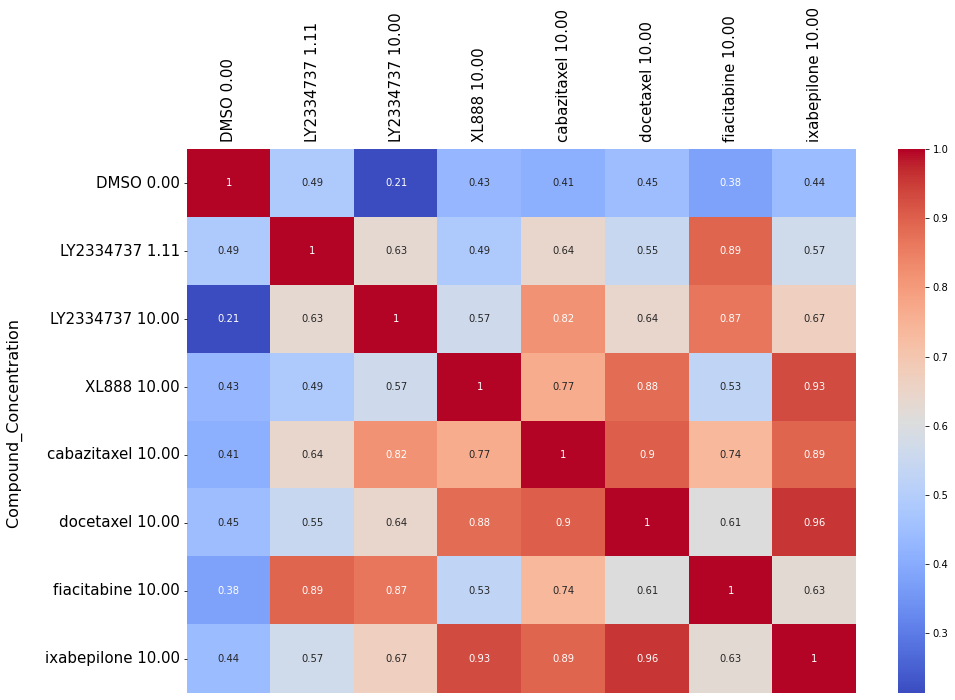

In [217]:
#@title Calculate correlations and plot similarity matrix
corr = corr_calculator(df_ag, strata = sort_by_corr)
corr_fig = plot_corr(corr, fig_size = (15, 10))

In [ ]:
#@title Save correlations plot
fname = input("Give this figure a name:")
img_format = ".png"
corr_fig.figure.savefig(fname+img_format, dpi = 200,  bbox_inches='tight')
files.download(fname+img_format)

Give this figure a name:x


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **5.1 Add correlations to DataFrame**



*   To allow the correlation value to determine the order in which we plot the images, we must add correlation values to the DataFrame.

In [218]:
#@title Correlation based on which sample?

#@markdown * We need to select which sample or treatment we want to have as a point of reference. 

#@markdown * Do you want to see how closely related are the treated cells in reference to a sample? Choose any sample you wish.
df_list = [option for option in df[sort_by].unique().tolist()]
dropdown(df_list)

Dropdown(description='Choose', options=('DMSO 0.00', 'XL888 10.00', 'ixabepilone 10.00', 'LY2334737 10.00', 'L…

In [219]:
#@title Save selected sample
corr_to = dropdown_output
print(corr_to)

DMSO 0.00


In [220]:
#@title Insert correlation values to the DataFrame based on your choice
insert_corr(df, corr, corr_to = corr_to, sort_by = sort_by)

{'DMSO 0.00': 1.0, 'LY2334737 1.11': 0.4858966482065006, 'LY2334737 10.00': 0.21375641974772022, 'XL888 10.00': 0.4288223083678236, 'cabazitaxel 10.00': 0.40867245282484527, 'docetaxel 10.00': 0.4463960310503926, 'fiacitabine 10.00': 0.37939396300999434, 'ixabepilone 10.00': 0.44384020220007264}


,Metadata_Concentration,Metadata_moa,Metadata_Compound,Metadata_Plate,Metadata_Well,Image_FileName_OrigAGP,Image_FileName_OrigDNA,Image_FileName_OrigER,Image_FileName_OrigMito,Image_FileName_OrigRNA,...,Nuclei_Texture_Variance_AGP_20_0,Nuclei_Texture_Variance_DNA_20_0,Nuclei_Texture_Variance_ER_20_0,Nuclei_Texture_Variance_Mito_20_0,Nuclei_Texture_Variance_RNA_10_0,Nuclei_Texture_Variance_RNA_20_0,Nuclei_Location_Center_X,Nuclei_Location_Center_Y,Metadata_Compound_Concentration,Correlation_to
0,0.00,DMSO,DMSO,SQ00015195,A02,r01c02f01p01-ch4sk1fk1fl1.tiff,r01c02f01p01-ch1sk1fk1fl1.tiff,r01c02f01p01-ch2sk1fk1fl1.tiff,r01c02f01p01-ch5sk1fk1fl1.tiff,r01c02f01p01-ch3sk1fk1fl1.tiff,...,0.213458,0.220092,0.475223,0.204038,-0.230087,0.035018,653.073964,32.750634,DMSO 0.00,1.00
1,0.00,DMSO,DMSO,SQ00015195,A02,r01c02f01p01-ch4sk1fk1fl1.tiff,r01c02f01p01-ch1sk1fk1fl1.tiff,r01c02f01p01-ch2sk1fk1fl1.tiff,r01c02f01p01-ch5sk1fk1fl1.tiff,r01c02f01p01-ch3sk1fk1fl1.tiff,...,-0.120852,1.905764,-0.150426,0.768826,0.265255,0.409967,1979.191781,47.390839,DMSO 0.00,1.00
2,0.00,DMSO,DMSO,SQ00015195,A02,r01c02f01p01-ch4sk1fk1fl1.tiff,r01c02f01p01-ch1sk1fk1fl1.tiff,r01c02f01p01-ch2sk1fk1fl1.tiff,r01c02f01p01-ch5sk1fk1fl1.tiff,r01c02f01p01-ch3sk1fk1fl1.tiff,...,-1.039545,0.514831,-0.770675,-0.574780,-0.569374,-0.445787,2080.545903,48.469193,DMSO 0.00,1.00
3,0.00,DMSO,DMSO,SQ00015195,A02,r01c02f01p01-ch4sk1fk1fl1.tiff,r01c02f01p01-ch1sk1fk1fl1.tiff,r01c02f01p01-ch2sk1fk1fl1.tiff,r01c02f01p01-ch5sk1fk1fl1.tiff,r01c02f01p01-ch3sk1fk1fl1.tiff,...,0.056879,0.067970,-0.750939,-0.117725,0.188915,0.462832,1120.825549,52.805403,DMSO 0.00,1.00
4,0.00,DMSO,DMSO,SQ00015195,A02,r01c02f01p01-ch4sk1fk1fl1.tiff,r01c02f01p01-ch1sk1fk1fl1.tiff,r01c02f01p01-ch2sk1fk1fl1.tiff,r01c02f01p01-ch5sk1fk1fl1.tiff,r01c02f01p01-ch3sk1fk1fl1.tiff,...,0.214775,-0.120186,0.799046,0.821123,0.209767,0.088538,1696.844459,78.116332,DMSO 0.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7572,10.00,DNA synthesis inhibitor,fiacitabine,SQ00015195,L19,r12c19f09p01-ch4sk1fk1fl1.tiff,r12c19f09p01-ch1sk1fk1fl1.tiff,r12c19f09p01-ch2sk1fk1fl1.tiff,r12c19f09p01-ch5sk1fk1fl1.tiff,r12c19f09p01-ch3sk1fk1fl1.tiff,...,1.320061,-2.053162,0.468402,-0.893960,-1.721692,-1.411222,257.289705,2091.924182,fiacitabine 10.00,0.38
7573,10.00,DNA synthesis inhibitor,fiacitabine,SQ00015195,L19,r12c19f09p01-ch4sk1fk1fl1.tiff,r12c19f09p01-ch1sk1fk1fl1.tiff,r12c19f09p01-ch2sk1fk1fl1.tiff,r12c19f09p01-ch5sk1fk1fl1.tiff,r12c19f09p01-ch3sk1fk1fl1.tiff,...,1.914382,-0.777660,0.448338,0.024980,0.500579,0.413282,1040.821322,2097.956493,fiacitabine 10.00,0.38
7574,10.00,DNA synthesis inhibitor,fiacitabine,SQ00015195,L19,r12c19f09p01-ch4sk1fk1fl1.tiff,r12c19f09p01-ch1sk1fk1fl1.tiff,r12c19f09p01-ch2sk1fk1fl1.tiff,r12c19f09p01-ch5sk1fk1fl1.tiff,r12c19f09p01-ch3sk1fk1fl1.tiff,...,0.957946,-2.608285,1.336558,-0.134796,1.604849,0.958992,1429.728495,2098.826344,fiacitabine 10.00,0.38
7575,10.00,DNA synthesis inhibitor,fiacitabine,SQ00015195,L19,r12c19f09p01-ch4sk1fk1fl1.tiff,r12c19f09p01-ch1sk1fk1fl1.tiff,r12c19f09p01-ch2sk1fk1fl1.tiff,r12c19f09p01-ch5sk1fk1fl1.tiff,r12c19f09p01-ch3sk1fk1fl1.tiff,...,0.058719,-1.027053,-0.726884,0.575325,0.150917,0.569167,1743.008311,2110.983646,fiacitabine 10.00,0.38


## **5.2 What are the five samples closer to the negative control?**

- We are evaluating the most correlated treatments to the negative control, but you could choose any sample you'd like.

In [221]:
#@title Run dropdown function
def dropdown(input_list):
  import ipywidgets as widgets
  global dropdown_output
  drop_down = widgets.Dropdown(options=input_list,
                                  description='Choose',
                                  disabled=False)

  def dropdown_handler(change):
      global dropdown_output
      dropdown_output = change.new  # This line isn't working
  drop_down.observe(dropdown_handler, names='value')
  display(drop_down)
  dropdown_output = drop_down.value


In [222]:
#@title Choose the baseline treatment or the compound you want to see the most correlated to.
df_list = [option for option in df[sort_by].unique().tolist()]
dropdown(df_list)

Dropdown(description='Choose', options=('DMSO 0.00', 'XL888 10.00', 'ixabepilone 10.00', 'LY2334737 10.00', 'L…

In [223]:
#@title Save chosen compound
ctrl = dropdown_output
print(ctrl)

DMSO 0.00


In [224]:
#@title Display top five compounds closest to baseline treatment
five_most_corr(df, corr, control = ctrl, sort_by = sort_by, add_moa = True)

Five compound most correlated to  DMSO 0.00


,Compound,Correlation,moa
0,LY2334737 1.11,0.485897,antitumor agent|ribonucleotide reductase inhib...
1,docetaxel 10.00,0.446396,tubulin polymerization inhibitor
2,ixabepilone 10.00,0.443840,microtubule stabilizing agent
3,XL888 10.00,0.428822,HSP inhibitor
4,cabazitaxel 10.00,0.408672,microtubule inhibitor


# **6. Visualize cells**



*   We can choose from one of the following methods to select the cells:
        random - generate n randomly selected cells
        representative - clusters the data and sample from the "closest to mean cluster"



In [225]:
#@title Choose the method to choose cells to plot:
def dropdown(input_list):
  import ipywidgets as widgets
  global dropdown_output
  drop_down = widgets.Dropdown(options=input_list,
                                  description='Choose',
                                  disabled=False)

  def dropdown_handler(change):
      global dropdown_output
      dropdown_output = change.new  # This line isn't working
  drop_down.observe(dropdown_handler, names='value')
  display(drop_down)
  dropdown_output = drop_down.value

choose_cells = ['random', 'representative']
dropdown(choose_cells)

Dropdown(description='Choose', options=('random', 'representative'), value='random')

In [226]:
#@title Run to save selected methods 
plot = dropdown_output
print(plot)

representative


In [227]:
#@title Use correlations to order the image plot? Choose Yes or No


def dropdown(input_list):
  import ipywidgets as widgets
  global dropdown_output
  drop_down = widgets.Dropdown(options=input_list,
                                  description='Choose',
                                  disabled=False)

  def dropdown_handler(change):
      global dropdown_output
      dropdown_output = change.new  # This line isn't working
  drop_down.observe(dropdown_handler, names='value')
  display(drop_down)
  dropdown_output = drop_down.value

choose_cells = ['yes', 'no']
dropdown(choose_cells)

Dropdown(description='Choose', options=('yes', 'no'), value='yes')

In [228]:
#@title Run to save selected methods 
corr_input = dropdown_output
corr_input_transform = stringToBool(corr_input)
print(corr_input)

yes


In [202]:
#@title Choose number of cells to plot for each group
import panel as pn
pn.extension()

int_slider = pn.widgets.IntSlider(name='How many cells would you like to plot for each subgroup?', start=1, end=10, step=1, value=1)

int_slider

IntSlider(end=10, name='How many cells w..., start=1, value=1)

In [203]:
#@title Run to save previous selection
val_ncells = int_slider.value
print(val_ncells)

1


In [241]:
#@title Select cells and add it to a new DataFrame

if plot == 'random':
    df_selected_smp = random_select(df, list_to_plot = list_to_plot, sort_by = sort_by, box_size = box_size, correlation = corr_input_transform, n_cells = val_ncells)
elif plot == 'representative':
    df_selected_smp = representative_kmeans_select(df, list_to_plot = list_to_plot, sort_by = sort_by, box_size = box_size, correlation = corr_input_transform, n_cells = val_ncells)

In [242]:
#@title Add the image path to the selected DataFrame
df_plot = add_path(
                df_selected_smp, images_dir, channels = channels, 
                compressed = True, 
                compressed_format = 'png'
                  )

In [166]:
#@title Choose whether or not you want the image intensities rescaled.

#@markdown Choose whether or not you want the image intensities rescaled. 

rescale_input = input("Visualize images with rescaled intensity or not rescaled? Type yes or no ")
rescale_input_transf = stringToBool(corr_input)

Visualize images with rescaled intensity or not rescaled? Type yes or no yes


In [65]:
#@title Provide the pixel size as μm/pixel 

#@markdown E.g. 1 pixel is equal to **0.3225 μm**, so provide **0.3225 μm/pixel** measure as an input. 

pixel_size_input = input("Write the pixel size in μm/pixel and press enter ")
pixel_size_int = float(pixel_size_input)


Write the pixel size in μm/pixel and press enter 0.3225


## **Plot cells**

* On the next code cell, you can customize depending on your preferences:
    - **label**: if label = True, you will see the labels on the left of each row.
    - **label_column** if you choose label = True, provide a string with the name of the column the user want to use as the label
    - **compressed**: specify if you're using a compressed version of your images to plot (i.e. they were acquired on tiff but you're using png images to plot)
    - **correlation**: if correlation = True, the order of images will consider the correlation calculated in step **5.1**. 


## **6.1 Plot cells in random order**

representative


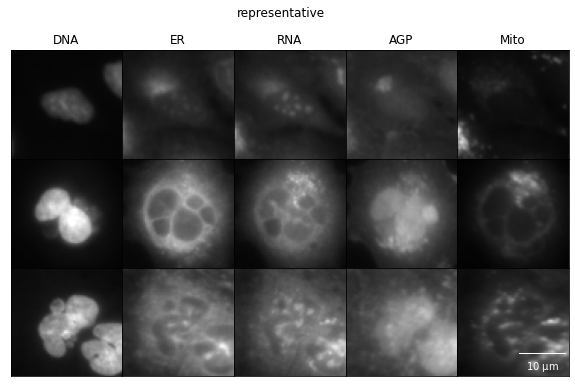

In [243]:
#@title Take a look at the images in a shuffled order, without the labels. 
#@markdown * Do you see any tendencies? Look at the nuclei size, intensity of the stains.

df_shuffle = df_plot.sample(frac=1).reset_index(drop=True)
fig_less_bias = visualize_n_SingleCell(channels,df_shuffle,box_size,title=plot,
compressed=True,compressed_im_size=1080,rescale=rescale_input_transf,scale_bar=True,pixel_size=pixel_size_int)

representative


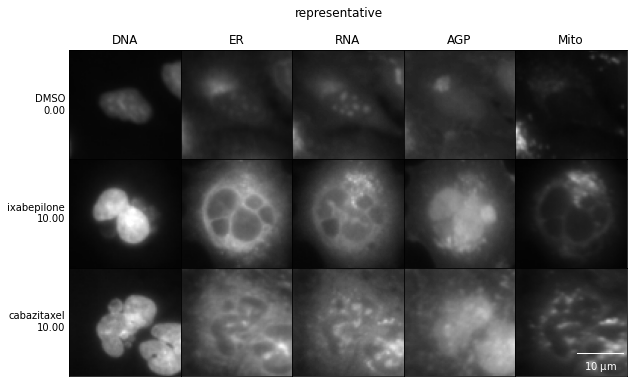

In [244]:
#@title Now look at the shuffled images with their labels. Can you think of any reasons why some cells are bigger, smaller?
fig_less_bias = visualize_n_SingleCell(channels,df_shuffle,box_size,title=plot,
compressed=True,compressed_im_size=1080, label=True, label_column=sort_by, rescale=rescale_input_transf,scale_bar=True,pixel_size=pixel_size_int)

## **6.2 Plot single cell based on method chosen in 6 (random or representative)**

representative


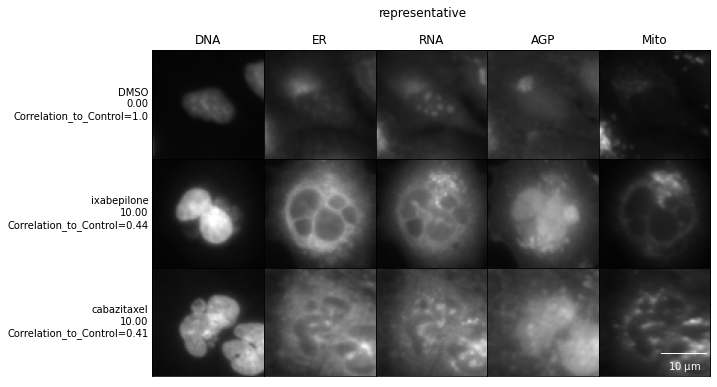

In [245]:
#@title Plot single-cells order by correlation
fig = visualize_n_SingleCell(channels,df_plot,box_size,label=True,label_column=sort_by,title=plot,
compressed=True,compressed_im_size=1080, correlation = True, rescale=rescale_input_transf,scale_bar=True,pixel_size=pixel_size_int)

In [246]:
#@title Save image
fname = input("Give this figure a name:")
img_format = ".png"
fig.savefig(fname+img_format, dpi = 200, bbox_inches='tight')
files.download(fname+img_format)

Give this figure a name:Fig6_representative


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **6.3 Plot images where cells above (section 6.2) are located**

- Visualize an entire representative field of view

representative


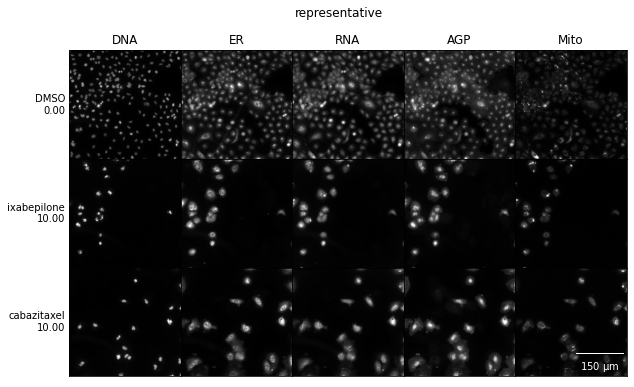

In [247]:
#@title Plot images
img = visualize_image(channels,df_plot,title=plot,label=True, label_column=sort_by,rescale=rescale_input_transf,scale_bar=True, pixel_size=pixel_size_int)

In [248]:
#@title Save image
fname = input("Give this figure a name:")
img_format = ".png"
img.savefig(fname+img_format, dpi = 200, bbox_inches='tight')
files.download(fname+img_format)

Give this figure a name:Fig6_representativeimage


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>